In [89]:
from scipy import signal as sg
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import control as ct
import time as tempo

In [90]:
dados_recebidos = np.load(r"Dados_SK.npy")
tempo_medido = dados_recebidos[:,0]
Ts = np.mean(tempo_medido).round(4)
Ts

0.0156

In [91]:
R1 = 1.0e3
R2 = 10e3
C1 = 3.3e-6
C2 = 3.3e-6

w0 = np.sqrt(1/(C1*C2*R1*R2))
xi = (1/(2*w0))*((1/(R1*C1))+(1/(R2*C2)))
xi

num = w0**2
den = [1,2*xi*w0, w0**2]
H = ct.tf(num,den)
Hz = ct.c2d(H,Ts,'tustin')
Hz

TransferFunction(array([0.13434022, 0.26868045, 0.13434022]), array([ 1.        , -0.21224165, -0.25039746]), 0.0156)

25


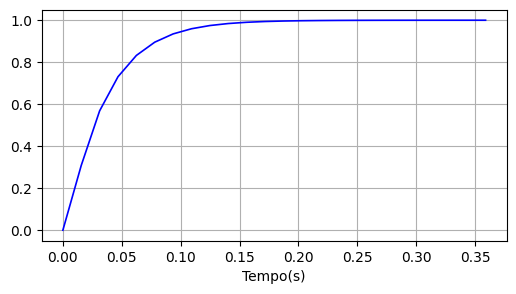

In [92]:
TempoTotal = 0.4
Ns = int(TempoTotal/Ts)
t = Ts*np.arange(0,Ns-1)
yc = ct.step_response(H,T=t)[1]
plt.figure(figsize=(6,3))
plt.plot(t,yc,'-b',linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.grid()

print(Ns)


# Identificação

In [93]:
sinal_entrada = dados_recebidos[:,1]
sinal_saida = dados_recebidos[:,2]

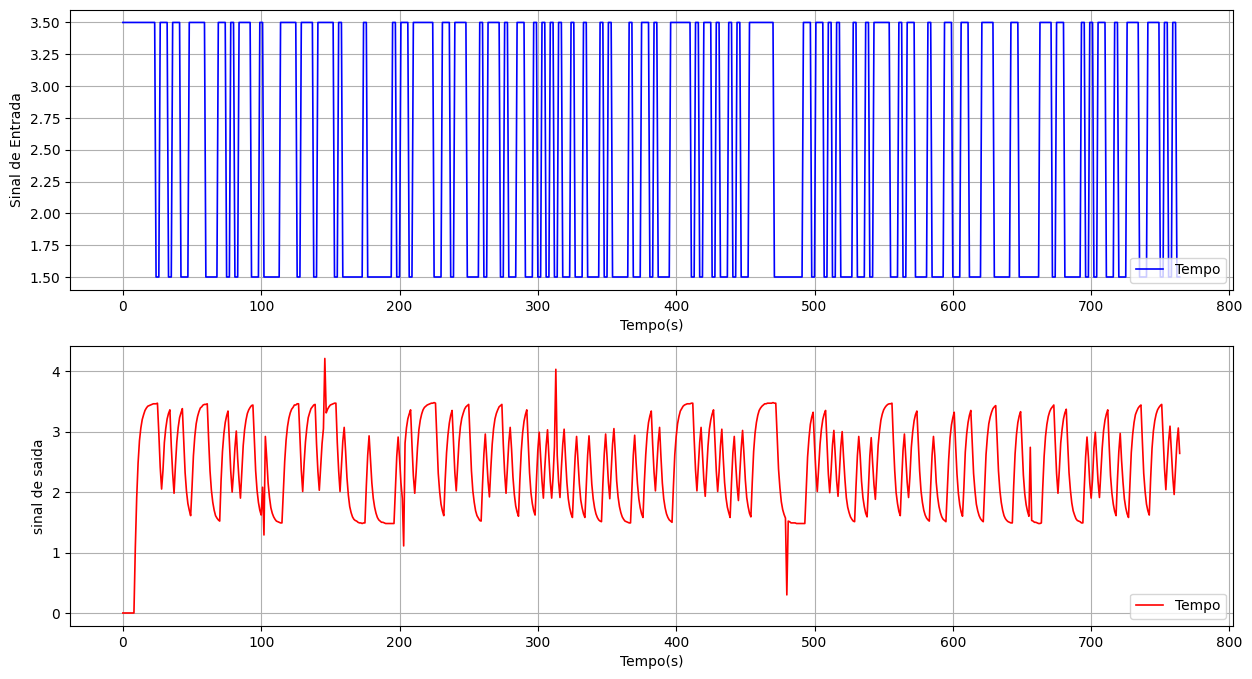

In [94]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(sinal_entrada,'-b',linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.ylabel('Sinal de Entrada')
plt.grid()
plt.legend(loc='lower right', labels=('Tempo','Sinal de entrada'))

plt.subplot(212)
plt.plot(sinal_saida,'r',linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.ylabel('sinal de saida')
plt.grid()
plt.legend(loc='lower right', labels=('Tempo','Sinal de saida'))
plt.savefig('SINAL_PRBS.png',bbox_inches='tight')
plt.show()

In [95]:
# Correção dos spikes!

In [96]:
Nt = 25
ur =sinal_entrada[Nt:]-2.5
yr = sinal_saida[Nt:]-np.mean(sinal_saida[Nt:])
N = len(ur)
t = Ts*np.arange(0,N)

In [97]:
percIdent = 0.7         # Percentual dos dados de identificação:
Ni = int(percIdent*N)   # Quantidade de amostras para identificação:
Ni

518

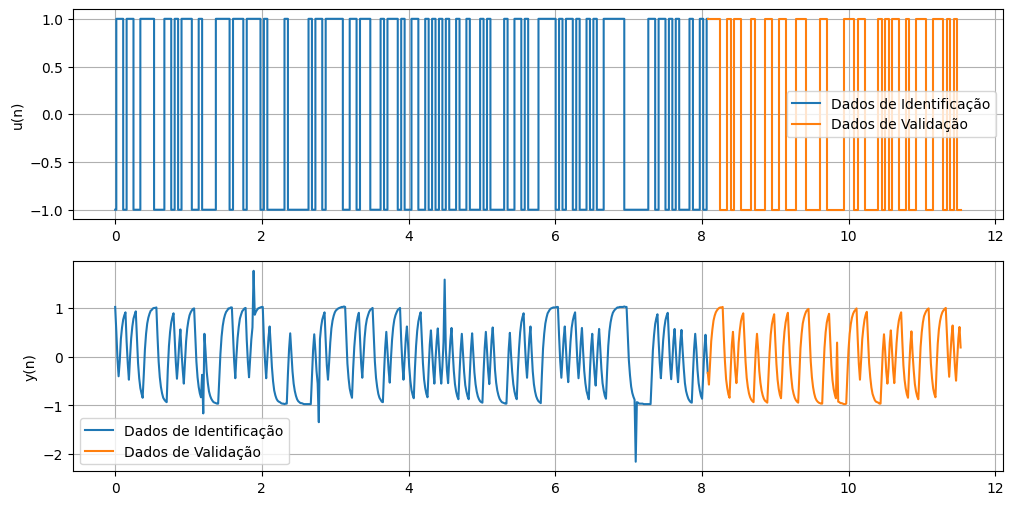

In [98]:
plt.figure(figsize = (12,6))
plt.subplot(211)
plt.step(t[:Ni+1],ur[:Ni+1],label='Dados de Identificação')
plt.step(t[Ni:],ur[Ni:],label='Dados de Validação')
plt.ylabel('u(n)')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(t[:Ni+1],yr[:Ni+1], label='Dados de Identificação')
plt.plot(t[Ni:],yr[Ni:],label='Dados de Validação')
plt.legend()
plt.grid()
plt.ylabel('y(n)')
plt.savefig('validação.png',bbox_inches='tight')
plt.show()

Hz

In [99]:
Hz

TransferFunction(array([0.13434022, 0.26868045, 0.13434022]), array([ 1.        , -0.21224165, -0.25039746]), 0.0156)

In [100]:
# Matriz de regressão:
nb = 3          #atraso em b
na = 2          #atraso em a
ni = np.arange(na,Ni+na)
M = np.zeros((Ni,na+nb))

M.shape

(518, 5)

In [101]:
# Regressores da saida y:
M[:,0] = yr[ni-1]
M[:,1] = yr[ni-2]

# Regressores da entrada u:
M[:,2] = ur[ni]
M[:,3] = ur[ni-1]
M[:,4] = ur[ni-2]




array([[ 0.5167027,  1.0167027,  1.       , -1.       , -1.       ],
       [-0.0432973,  0.5167027,  1.       ,  1.       , -1.       ],
       [-0.4032973, -0.0432973,  1.       ,  1.       ,  1.       ],
       ...,
       [ 0.4467027,  0.1467027, -1.       , -1.       , -1.       ],
       [ 0.0367027,  0.4467027,  1.       , -1.       , -1.       ],
       [-0.3332973,  0.0367027,  1.       ,  1.       , -1.       ]])

In [106]:
# Mínimos quadrados
theta = np.linalg.inv(M.T@M)@M.T@yr[ni]

theta

array([ 0.69281522, -0.02055789, -0.00858786, -0.01291312,  0.34316042])

In [107]:
A = np.array([1, -theta[0],-theta[1]])
B = np.array([theta[2], theta[3], theta[4]])
Gz = ct.tf(B,A,dt = Ts)
print(Gz)
print(Hz)


-0.008588 z^2 - 0.01291 z + 0.3432
----------------------------------
     z^2 - 0.6928 z + 0.02056

dt = 0.0156


0.1343 z^2 + 0.2687 z + 0.1343
------------------------------
   z^2 - 0.2122 z - 0.2504

dt = 0.0156



In [109]:
# yp = sg.dlsim(Gz, sinal_entrada, t = t)[1]
t = Ts*np.arange(0,N)
_, ys = ct.forced_response(Hz, T=t,U = ur)
_, yp = ct.forced_response(Gz, T=t,U = ur)

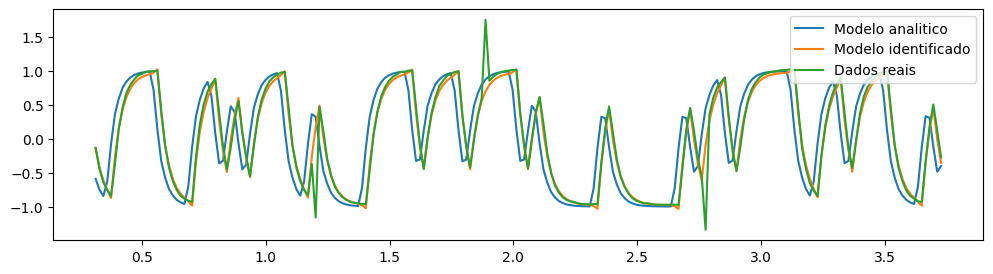

In [116]:

# Resposta do modelo identificado:
inicio = 20
fim = 240
plt.figure(figsize = (12,3))
plt.plot(t[inicio:fim],ys[inicio:fim],label='Modelo analitico')
plt.plot(t[inicio:fim],yp[inicio:fim],label='Modelo identificado')
plt.plot(t[inicio:fim],yr[inicio:fim],label='Dados reais')
plt.legend()

plt.show()

In [115]:
from sklearn.metrics import r2_score as AjusteR2

print('Ajuste Analitico x Identificado: ', AjusteR2(ys,yp).round(3))
print('Ajuste Analitico x Dados reais: ', AjusteR2(ys,yr).round(3))
print('Ajuste Identificado x Dados reais: ', AjusteR2(yp,yr).round(3))


Ajuste Analitico x Identificado:  0.578
Ajuste Analitico x Dados reais:  0.532
Ajuste Identificado x Dados reais:  0.963


In [117]:
Hz

TransferFunction(array([0.13434022, 0.26868045, 0.13434022]), array([ 1.        , -0.21224165, -0.25039746]), 0.0156)